# Support Vector Regression

For this notebook, we will work with a version of the [Cement Strength Dataset](https://www.kaggle.com/pavanraj159/concrete-compressive-strength-data-set).
The dataset contains different mixtures of cement (depending on grain size, types of cement, water amount, age in days etc) and how they relate to the compression strength (csMPa) of the resulting cement block.
Your task will be implementing different models and perfoming a grid search to find the best one.

In [1]:
# load and show dataset
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
#set_matplotlib_formats('svg')
sns.set_style("darkgrid")

In [2]:
data = pd.read_csv('concrete_strength.csv')
data

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [3]:
X = data.drop(columns=['csMPa'])
y = data['csMPa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=350)

__Task__: First, get an intuition about the dataset. Select a plot of your choice!

_Remark_: I use rendering in svg mode to get nice vector graphics. When doing a pairplot for medium to big sized datasets this might run a while on a standard machine. Also keep in mind: The pairplot (or also reffered to as scatter matrix) generates $K^2$ scatter plots!

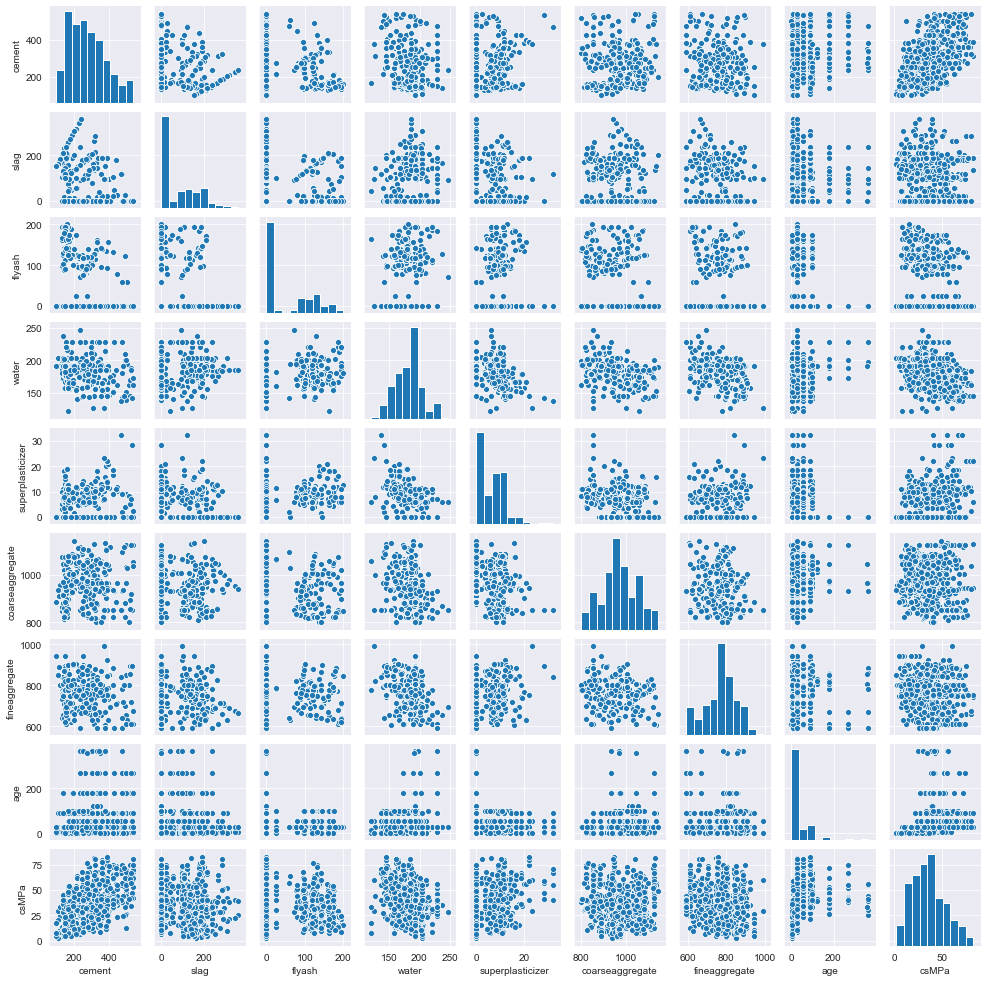

In [4]:
pp=sns.pairplot(pd.concat([X_train,y_train],axis=1),height=1.5)

Let us try a linear model first. 

__Task__: Perform a grid search using cross-validation to find the best hyper-parameter(s) for a _linear_ SVR!

_Remark_: It is easy to think that a scaler/transformer within the pipeline does the whole job. But here we want to show you that the scaler in a pipeline only works on $X$ and not on $y$. Transforming $y$ is often regarded as not so important, especially when we have a vector $y$. But there are cases where you want to transform your dependent variable(s). This can be done by using a `TransformedTargetRegressor` as shown below.
According to our lecutre resource "Applied Predictive Modeling" it can be shown that $\epsilon$ and $C$ are somehow connected to each other. So we perfrom the gridsearch only over the parameter $C$.

In [5]:
# grid search linear svm
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor

sc = StandardScaler()
linsvr = SVR(kernel='linear')

cval = KFold(n_splits=10)
pipe = Pipeline([('scaler', sc),('svr', linsvr)])
model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
param_grid = {'regressor__svr__C' : [0.01, 0.02,0.05,0.1,0.2,0.5,1,2,5,10,20],}
            
search = GridSearchCV(model, param_grid, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
search.fit(X_train, y_train)
print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
print(search.best_params_)

Best parameter RMSE=10.819):
{'regressor__svr__C': 0.02}


__Task__: Plot your cross-validation score over the hyper-paramter(s) used in the grid search!

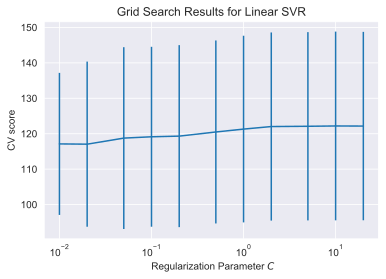

In [6]:
set_matplotlib_formats('svg')
plt.figure()
plt.errorbar(param_grid['regressor__svr__C'],-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'])
plt.xticks(param_grid['regressor__svr__C'])
plt.xlabel(" Regularization Parameter $C$")
plt.ylabel("CV score")
plt.title("Grid Search Results for Linear SVR")
ax = plt.gca()
ax.set_xscale('log')
plt.show()

__Task__: Plot the residuals vs the predicted values and indicate the support vectors (i.e.try to reproduce the plot in the book Applied Predictive Modeling, p. 156)!

_Remark_: As we used a regressor and a pipeline, we have to navigate through these objects to finally access the SVR-object, which holds the attribute `.support_`.  

104 samples have not been chosen to be support vectors.


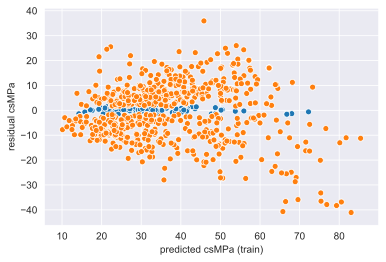

In [7]:
best_estimator_linear = search.best_estimator_
y_pred_train = best_estimator_linear.predict(X_train)
y_pred_test = best_estimator_linear.predict(X_test)

sp_idx = best_estimator_linear.regressor_['svr'].support_ 

print(str(len(y_train)-len(sp_idx)) + ' samples have not been chosen to be support vectors.') 

plt.figure()
sns.scatterplot(x=y_pred_train, y=y_train-y_pred_train)
sns.scatterplot(x=y_pred_train[sp_idx], y=y_train.values[sp_idx]-y_pred_train[sp_idx])
plt.xlabel('predicted csMPa (train)')
plt.ylabel('residual csMPa')
plt.show()

Check the final performance on the test set!

RMSE training fit: 10.668
R2 training fit: 0.612 
RMSE prediction: 10.774
R2 prediction: 0.507 


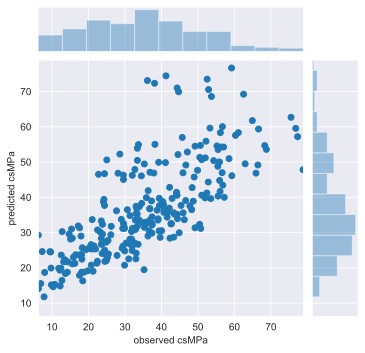

In [8]:
print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y_train,y_pred_train)))
print("R2 training fit: %.03f " %r2_score(y_train,y_pred_train))
print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

minlim = y_test.min()
maxlim = y_test.max()
# predicted/actual plot for test set
ax = sns.jointplot(x=y_test,y=y_pred_test, height=5,xlim=(minlim,maxlim),ylim=(minlim,maxlim))
ax.ax_joint.set_xlabel('observed csMPa')
ax.ax_joint.set_ylabel('predicted csMPa')
plt.show()

Let us see if a non-linear model can do a better job by choosing a SVR with RBF-kernel.

__Task__: Perfrom a grid search by cross-validation to tune the hyper-parameter(s) for a SVR with _RBF-kernel_!

_Remark_: Again, we will not tune the $\epsilon$. But we now have an additional parameter for the kernel: $\gamma$.

In [9]:
# grid search non-linear svr
sc = StandardScaler()
svr = SVR(kernel='rbf')
gsC = [0.5,1,2,5,10,100,1000,10000]
gsG = np.logspace(-7,2,10)
cval = KFold(n_splits=10)
pipe = Pipeline([('scaler', sc),('svr', svr)])
model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
param_grid = {'regressor__svr__C' : gsC,
              'regressor__svr__gamma': gsG }

search = GridSearchCV(model, param_grid, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
search.fit(X_train, y_train)
print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
print(search.best_params_)

Best parameter RMSE=5.796):
{'regressor__svr__C': 10000, 'regressor__svr__gamma': 0.01}


__Task__: Plot your corss-validation score over the hyper-paramter(s) used in the grid search!

_Remark_: The gridsearch results are stored in a dictionary. The scores are stored sequentially in a 1D numpy array. But we need a 2D array to visualize the error for all combinations of $C$ and $\gamma$. To see the corresponding parameter for a score you can have a look in to the list `params`. The cell below sould can be used to check it by inspection.

In [10]:
print(search.cv_results_['params'][:8])
print(-search.cv_results_['mean_test_score'][:8])
-search.cv_results_['mean_test_score'].reshape(len(gsC),len(gsG))[:2,:]

[{'regressor__svr__C': 0.5, 'regressor__svr__gamma': 1e-07}, {'regressor__svr__C': 0.5, 'regressor__svr__gamma': 1e-06}, {'regressor__svr__C': 0.5, 'regressor__svr__gamma': 1e-05}, {'regressor__svr__C': 0.5, 'regressor__svr__gamma': 0.0001}, {'regressor__svr__C': 0.5, 'regressor__svr__gamma': 0.001}, {'regressor__svr__C': 0.5, 'regressor__svr__gamma': 0.01}, {'regressor__svr__C': 0.5, 'regressor__svr__gamma': 0.1}, {'regressor__svr__C': 0.5, 'regressor__svr__gamma': 1.0}]
[294.91578662 294.70263709 292.56534958 273.0787365  177.55971705
  86.51968484  57.20597245  85.38748239]


array([[294.91578662, 294.70263709, 292.56534958, 273.0787365 ,
        177.55971705,  86.51968484,  57.20597245,  85.38748239,
        186.95275531, 238.23946927],
       [294.89209141, 294.46598226, 290.20859437, 254.65878928,
        141.2933723 ,  74.81260276,  48.23874916,  62.08478867,
        155.29117195, 217.43690577]])

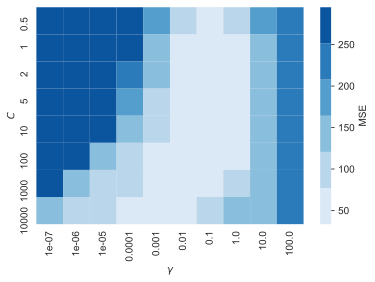

In [11]:
plt.figure()
sns.heatmap(-search.cv_results_['mean_test_score'].reshape(len(gsC),len(gsG)),
            cmap=sns.color_palette("Blues"),annot=False,
           xticklabels=gsG, yticklabels=gsC,
           cbar_kws={'label': 'MSE'})
plt.xlabel('$\gamma$')
plt.ylabel('$C$')
plt.show()

Check the final performance on the test set!

RMSE training fit: 4.171
R2 training fit: 0.941 
RMSE prediction: 6.314
R2 prediction: 0.831 


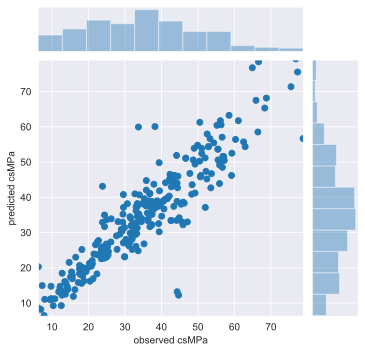

In [12]:
# evaluation rbf svr
best_estimator_rbf = search.best_estimator_
y_pred_train = best_estimator_rbf.predict(X_train)
y_pred_test = best_estimator_rbf.predict(X_test)

print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y_train,y_pred_train)))
print("R2 training fit: %.03f " %r2_score(y_train,y_pred_train))
print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

minlim = y_test.min()
maxlim = y_test.max()
# predicted/actual plot for test set
ax = sns.jointplot(x=y_test,y=y_pred_test, height=5,xlim=(minlim,maxlim),ylim=(minlim,maxlim))
ax.ax_joint.set_xlabel('observed csMPa')
ax.ax_joint.set_ylabel('predicted csMPa')
#plt.suptitle("Results of Linear+RBF SVM gridsearch, Cement dataset")
plt.show()

Sometimes it might take a while to train a model. If you want to use a trained model later on you can save it using pickle ([SciKit Learn Docs: Model Persistence](https://scikit-learn.org/stable/modules/model_persistence.html))

__Task__: Save your trained RBF-SVR model using pickle!

In [13]:
import pickle
pkl_filename = "svm_linear_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_estimator_linear, file)

pkl_filename = "svm_rbf_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_estimator_rbf, file)